In [1]:
import os
os.chdir('/content/drive/MyDrive/dacon_cup/2차_open_data/open_data')

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
#!pip install lightgbm
from lightgbm import LGBMRegressor

# import zipfile 
# with zipfile.ZipFile("open_data.zip") as zf:
#   zf.extractall()

## 데이터

In [2]:
train1 = pd.read_csv('1차_open_data/train.csv', encoding='cp949')
train2 = pd.read_csv('2차_open_data/2차_train.csv', encoding='cp949')
train = pd.concat([train1,train2],axis=0)
submission = pd.read_csv('1차_open_data/submission.csv', encoding='cp949')

info_comp = pd.read_csv('2차_추가데이터/new_competition_info.csv', encoding='cp949')
info_login = pd.read_csv('2차_추가데이터/new_login_info.csv', encoding='cp949')
info_user = pd.read_csv('2차_추가데이터/new_user_info.csv', encoding='cp949')
info_sub = pd.read_csv('2차_추가데이터/new_submission_info.csv', encoding='cp949')

train.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2018-09-09 00:00:00,19,19,8,206
1,2018-09-09 01:00:00,20,19,9,259
2,2018-09-09 02:00:00,12,9,1,48
3,2018-09-09 03:00:00,10,10,2,102
4,2018-09-09 04:00:00,6,5,3,18


In [3]:
# train 데이터 일별로 summary

train['DateTime'] = pd.to_datetime(train['DateTime'])
train['date'] = train['DateTime'].dt.date
train  = train.groupby('date').sum().reset_index()
train.tail()

,date,사용자,세션,신규방문자,페이지뷰
817,2020-12-04,3189,3068,743,75730
818,2020-12-05,2055,2019,497,47638
819,2020-12-06,2119,2077,460,46914
820,2020-12-07,2979,2988,753,77443
821,2020-12-08,3033,2990,772,68857


In [4]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train['date'], y=train['사용자']))

## Feature Extraction

In [5]:
# 모든 값이 결측치인 행은 제거

comp = info_comp.dropna(how='all')
login = info_login.dropna(how='all')
user = info_user.dropna(how='all')
sub = info_sub.dropna(how='all')

In [6]:
# comp 데이터 일별로 summary

comp['period_start'] = pd.to_datetime(comp['period_start'])
comp['period_end'] = pd.to_datetime(comp['period_end'])

comp['start_date'] = comp['period_start'].dt.date
comp['end_date'] = comp['period_end'].dt.date

start_comp_fe = comp.groupby('start_date').count().reset_index()[['start_date','cpt_id']]
start_comp_fe.columns = ['date','start_comp_count']

end_comp_fe = comp.groupby('end_date').count().reset_index()[['end_date','cpt_id']]
end_comp_fe.columns = ['date','end_comp_count']

start_comp_fe.head() # 날짜별 대회 시작 수

,date,start_comp_count
0,2018-08-14,1
1,2018-09-15,1
2,2018-10-18,1
3,2018-11-13,1
4,2018-12-25,1


In [7]:
end_comp_fe.head() # 날짜별 대회 마감 수

,date,end_comp_count
0,2018-09-13,1
1,2018-10-13,1
2,2018-12-31,1
3,2019-01-10,1
4,2019-01-31,1


In [8]:
# login 데이터 일별로 summary

login['c_time'] = pd.to_datetime(login['c_time'])
login['date'] = login['c_time'].dt.date
login_fe = login.groupby('date').nunique().reset_index().drop(['Unnamed: 0','c_time'],axis=1)
login_fe.columns = ['date','login_count','login_user','login_platform','login_browser']
login_fe.head()  # 날짜별 총 로그인 수, 접속한 유저 수, 사용한 플랫폼 수, 사용한 브라우저 수

,date,login_count,login_user,login_platform,login_browser
0,2018-09-23,35,18,6,11
1,2018-09-24,30,21,5,12
2,2018-09-25,18,14,2,6
3,2018-09-26,48,29,5,10
4,2018-09-27,31,23,3,9


In [9]:
# user 데이터 일별로 summary

user['c_time'] = pd.to_datetime(user['c_time'])
user['date'] = user['c_time'].dt.date
user_fe = user.groupby('date').count()['id'].reset_index()
user_fe.columns = ['date','user_count']
user_fe.head() # 날짜별 가입 유저 수

,date,user_count
0,2017-05-02,1
1,2018-08-08,6
2,2018-08-09,1
3,2018-08-10,2
4,2018-08-12,1


In [10]:
# submission 데이터 일별로 summary

sub['c_time'] = pd.to_datetime(sub['c_time'])
sub['date'] = sub['c_time'].dt.date
sub_fe = sub.groupby('date').nunique().reset_index().drop(['Unnamed: 0','c_time'],axis=1)
sub_fe.columns = ['date','sub_count','sub_cpt','sub_team','sub_user']
sub_fe.head() # 날짜별 총 제출 횟수, 제출이 발생한 대회 수, 제출한 팀 수, 제출한 유저 수

,date,sub_count,sub_cpt,sub_team,sub_user
0,2018-08-14,2,1,2,2
1,2018-08-15,1,1,1,1
2,2018-08-16,1,1,1,1
3,2018-08-17,1,1,1,1
4,2018-08-18,2,1,2,2


In [11]:
# date 기준으로 feauture 전부 결합하여 최종 train 데이터셋 구축

train_X = pd.merge(train,start_comp_fe,on='date',how='left')
train_X = pd.merge(train_X,end_comp_fe,on='date',how='left')
train_X = pd.merge(train_X,login_fe,on='date',how='left')
train_X = pd.merge(train_X,user_fe,on='date',how='left')
train_X = pd.merge(train_X,sub_fe,on='date',how='left')

# 요일 및 주말여부 feature 생성
train_X['weekday'] = pd.to_datetime(train_X['date']).dt.weekday  # 요일
train_X['holiday'] = [1 if (x == 5) | (x==6) else 0 for x in train_X['weekday']]  # 주말 여부

train_X = train_X.fillna(0)

train_X.head()

,date,사용자,세션,신규방문자,페이지뷰,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user,weekday,holiday
0,2018-09-09,281,266,73,1826,0.0,0.0,0.0,0.0,0.0,0.0,9.0,71.0,1.0,18.0,18.0,6,1
1,2018-09-10,264,247,51,2092,0.0,0.0,0.0,0.0,0.0,0.0,4.0,74.0,1.0,21.0,21.0,0,0
2,2018-09-11,329,310,58,1998,0.0,0.0,0.0,0.0,0.0,0.0,6.0,94.0,1.0,22.0,22.0,1,0
3,2018-09-12,300,287,45,2595,0.0,0.0,0.0,0.0,0.0,0.0,2.0,93.0,1.0,21.0,21.0,2,0
4,2018-09-13,378,344,50,3845,0.0,1.0,0.0,0.0,0.0,0.0,7.0,94.0,1.0,26.0,26.0,3,0


In [12]:
# test 데이터셋도 동일하게 생성

submission['DateTime'] = submission['DateTime'].astype(str)
start_comp_fe['date'] = start_comp_fe['date'].astype(str)
end_comp_fe['date'] = end_comp_fe['date'].astype(str)
login_fe['date'] = login_fe['date'].astype(str)
user_fe['date'] = user_fe['date'].astype(str)
sub_fe['date'] = sub_fe['date'].astype(str)

temp_sub = submission[['DateTime']]
temp_sub.columns = ['date']

test_X = pd.merge(temp_sub,start_comp_fe,on='date',how='left')
test_X = pd.merge(test_X,end_comp_fe,on='date',how='left')
test_X = pd.merge(test_X,login_fe,on='date',how='left')
test_X = pd.merge(test_X,user_fe,on='date',how='left')
test_X = pd.merge(test_X,sub_fe,on='date',how='left')

# 요일 및 주말여부 feature 생성
test_X['weekday'] = pd.to_datetime(test_X['date']).dt.weekday
test_X['holiday'] = [1 if (x == 5) | (x==6) else 0 for x in test_X['weekday']]

test_X = test_X.fillna(0)

test_X.head()

,date,start_comp_count,end_comp_count,login_count,login_user,login_platform,login_browser,user_count,sub_count,sub_cpt,sub_team,sub_user,weekday,holiday
0,2020-11-09,0.0,0.0,460,397,0,0,162,511,20,224,212,0,0
1,2020-11-10,0.0,0.0,356,315,0,0,75,504,13,218,213,1,0
2,2020-11-11,2.0,0.0,504,398,0,0,86,587,15,247,237,2,0
3,2020-11-12,0.0,0.0,394,332,0,0,61,571,17,251,245,3,0
4,2020-11-13,0.0,2.0,397,332,0,0,74,609,18,263,265,4,0


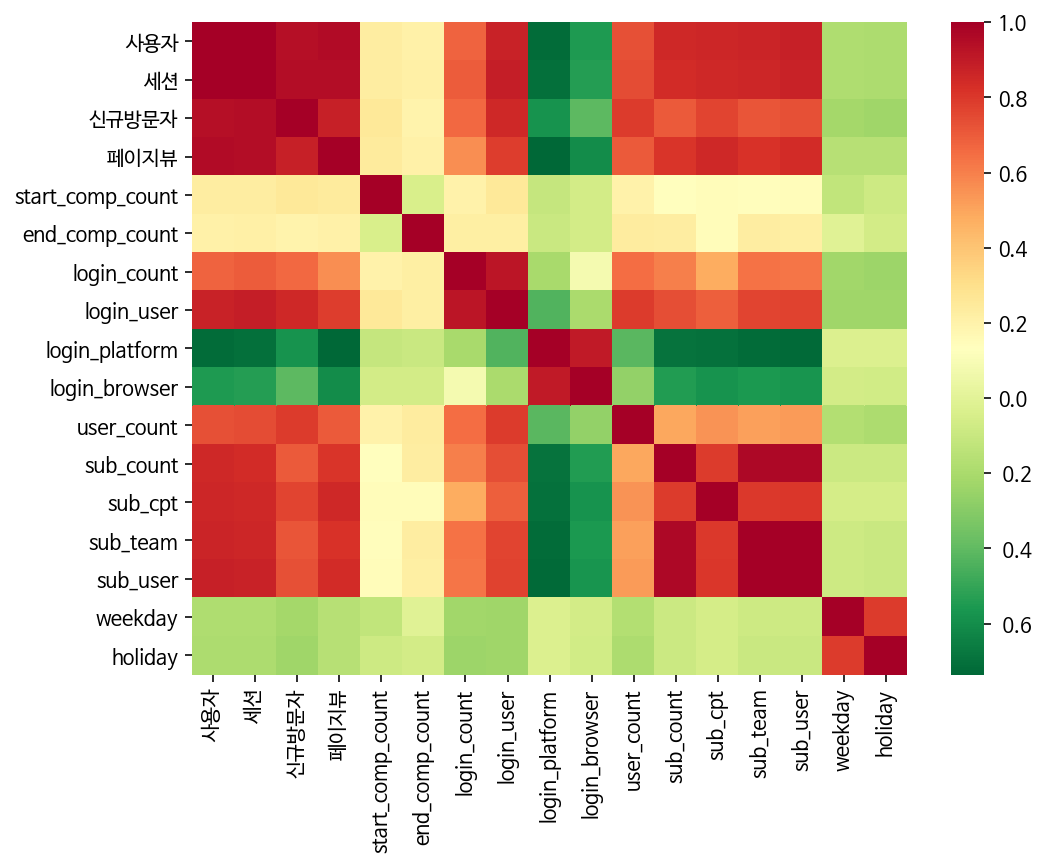

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(train_X.corr(), cmap='RdYlGn_r')

# 사용자,세션,신규방문자,페이지뷰는 서로 비슷한 양상을 보임
# 날짜별 총 로그인 수, 접속한 유저 수, 가입 유저 수, 총 제출 수, 제출이 발생한 대회 수, 제출한 팀 수, 제출한 유저 수가 종속변수들과 높은 상관관계를 보임

# Model

In [ ]:
# 독립변수와 종속변수 분할

y_user = train_X.iloc[:,1]
y_session = train_X.iloc[:,2]
y_visit = train_X.iloc[:,3]
y_view = train_X.iloc[:,4]

X_train = train_X.iloc[:,5:]
X_test = test_X.iloc[:,1:]

In [ ]:
# 최소-최대 정규화 수행

ms = MinMaxScaler()
X_train_m = pd.DataFrame(ms.fit_transform(X_train))
X_test_m = pd.DataFrame(ms.transform(X_test))

In [ ]:
# 개별 모델 성능 (RMSE) 확인

knn_model = KNeighborsRegressor()
svr_model = SVR()
lr_model = LinearRegression()
rf_model = RandomForestRegressor()
lgb_model = LGBMRegressor()

In [ ]:
cross_score_knn = cross_val_score(knn_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)
cross_score_lr = cross_val_score(lr_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)
cross_score_svr = cross_val_score(svr_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)
cross_score_rf = cross_val_score(rf_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)
cross_score_lgb = cross_val_score(lgb_model, X_train_m, y_user, scoring='neg_mean_squared_error', cv=5)


r_score_knn = np.sqrt(-cross_score_knn)
r_score_lr = np.sqrt(-cross_score_lr)
r_score_svr = np.sqrt(-cross_score_svr)
r_score_rf = np.sqrt(-cross_score_rf)
r_score_lgb = np.sqrt(-cross_score_lgb)

In [ ]:
print("KNN score :",r_score_knn, " / KNN mean score", r_score_knn.mean())
print("LR score :",r_score_lr, " / LR mean score", r_score_lr.mean())
print("SVR score :",r_score_svr, " / SVR mean score", r_score_svr.mean())
print("RF score :",r_score_rf, " / SVR mean score", r_score_rf.mean())
print("LGB score :",r_score_lgb, " / SVR mean score", r_score_lgb.mean())

KNN score : [319.5788471  186.80204009 451.77081579 493.64866123 914.11989847]  / KNN mean score 473.18405253623314
LR score : [207.1418869  236.50166626 341.35193628 256.32162566 399.16717389]  / LR mean score 288.09685779866646
SVR score : [ 980.54278522  838.44540524  467.66577595 1300.37450078 2315.99100601]  / SVR mean score 1180.6038946405856
RF score : [276.72644792 176.07377115 552.71587197 323.83386142 686.562731  ]  / SVR mean score 403.1825366939142
LGB score : [247.03656244 169.92058529 444.31790294 370.21512513 688.04037992]  / SVR mean score 383.9061111458001


# Prediction

In [ ]:
# 선형회귀 모델 적합 및 예측 - 사용자

lr_model = LinearRegression()
lr_model.fit(X_train_m,y_user)
submission['사용자'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4829.770868,0,0,0
1,2020-11-10,3860.936865,0,0,0
2,2020-11-11,4525.187248,0,0,0
3,2020-11-12,4183.208073,0,0,0
4,2020-11-13,4448.421141,0,0,0


In [ ]:
# 선형회귀 모델 적합 및 예측 - 세션

lr_model = LinearRegression()
lr_model.fit(X_train_m,y_session)
submission['세션'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4829.770868,4809.080458,0,0
1,2020-11-10,3860.936865,3780.574739,0,0
2,2020-11-11,4525.187248,4449.311623,0,0
3,2020-11-12,4183.208073,4071.301398,0,0
4,2020-11-13,4448.421141,4304.111452,0,0


In [ ]:
# 선형회귀 모델 적합 및 예측 - 신규방문자

lr_model = LinearRegression()
lr_model.fit(X_train_m,y_visit)
submission['신규방문자'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4829.770868,4809.080458,1268.756167,0
1,2020-11-10,3860.936865,3780.574739,877.008108,0
2,2020-11-11,4525.187248,4449.311623,1069.380029,0
3,2020-11-12,4183.208073,4071.301398,904.292607,0
4,2020-11-13,4448.421141,4304.111452,953.762049,0


In [ ]:
# 선형회귀 모델 적합 및 예측 - 페이지뷰

lr_model = LinearRegression()
lr_model.fit(X_train_m,y_view)
submission['페이지뷰'] = lr_model.predict(X_test_m)
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4829.770868,4809.080458,1268.756167,122955.782049
1,2020-11-10,3860.936865,3780.574739,877.008108,95122.483688
2,2020-11-11,4525.187248,4449.311623,1069.380029,113464.677781
3,2020-11-12,4183.208073,4071.301398,904.292607,101835.723549
4,2020-11-13,4448.421141,4304.111452,953.762049,120353.409830


# Submission

In [ ]:
submission.to_csv('submission'.csv',index=False,encoding='cp949')